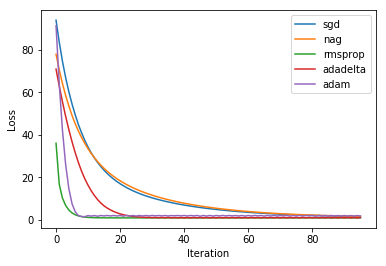

In [6]:
from sklearn.datasets import load_svmlight_file
from sklearn.model_selection import train_test_split
import numpy as np
from numpy import random
import matplotlib.pyplot as plt
import os

feature_size = 123
bias = np.zeros(shape=[feature_size + 1, 1])
bias[len(bias)-1][0] = 1.

def get_data():
    data = load_svmlight_file("a9a")
    x_train = data[0].toarray()
    y_train = data[1]
    temp = np.ones(shape=[32561, 1], dtype=np.float32)
    x_train = np.concatenate([x_train, temp], axis=1)
    return x_train, y_train

def get_test():
    data = load_svmlight_file("a9a.t")
    x_test = data[0].toarray()
    y_test = data[1]
    temp = np.zeros(shape=[16281, 1], dtype=np.float32)
    temp1 = np.ones(shape=[16281, 1], dtype=np.float32)
    x_test = np.concatenate([x_test, temp, temp1], axis=1)
    return x_test, y_test

def loss(x, y, w):
    pred = np.matmul(x, w)
    hinge_loss = np.maximum(1 - y * pred, 0)
    loss = np.mean(hinge_loss ** 2) + np.sum((w - bias) ** 2)
    return loss

def gradient(x, y, w):
    pred = np.matmul(x, w)
    hinge_loss = np.maximum(1 - y * pred, 0)
    hinge_loss_gradient = -np.matmul(x.transpose(), hinge_loss * y) / len(y)
    norm_gradient = 2 * (w - bias)
    gradient = hinge_loss_gradient + norm_gradient
    return gradient 

def optimizer(method, x, y, w):
    global global_list
    
    if method == 'sgd':
        rate = 0.01
         
        w -= rate * gradient(x, y, w)
        
    if method == 'nag':
        rate = 0.01
        miu = 0.9
        momentum = 0
        grad = gradient(x, y, w - momentum * rate * miu)
        momentum = momentum * rate + grad
        w -= rate * momentum
        
    if method == 'rmsprop':
        rate = 0.1
        e = 1
        rho = 0.95
        delta = 10e-7
        grad = gradient(x, y, w)
        expectation = rho * e + (1 - rho) * (grad ** 2)
        w -= rate * grad / (np.sqrt(expectation) + delta)
        
    if method == 'adam':
        delta = 10e-7
        rho1 = 0.9
        rho2 = 0.999
        rate = 0.1
        s = 0
        r = 0    
        grad = gradient(x, y, w)
        s = rho1 * s + (1 - rho1) * grad
        r = rho2 * r + (1 - rho2) * (grad ** 2)
        s_hat = s / (1 - rho1)
        r_hat = r / (1 - rho2)
        w -= (rate * s_hat) / (np.sqrt(r_hat) + delta)

    if method == 'adadelta':
        r = 0
        e = 0
        miu = 0.9
        delta = 10e-7
        rate = 10        
        grad = gradient(x, y, w)
        r = miu * r + (1 - miu) * (grad ** 2)
        w -= (rate * grad * np.sqrt(e + delta)) / (np.sqrt(r + delta))
        e = miu * e + (1 - miu) * (w ** 2)

def main():
    x_train, y_train = get_data()
    x_test, y_test = get_test()

    num_samples, num_features = x_train.shape
    num_test_samples, num_test_features = x_test.shape

    y_train = y_train.reshape([len(y_train), 1])
    y_test = y_test.reshape([len(y_test), 1])


    def shuffle_train(x_train, y_train):
        rng_state = np.random.get_state()
        np.random.shuffle(x_train)
        np.random.set_state(rng_state)
        np.random.shuffle(y_train)

    batch_size = 1024
    data_size = num_samples

    def feed_data(batch_count):
        if (1 + batch_count) * batch_size <= data_size:
            feed_dict = {'x': x_train[batch_count * batch_size:(batch_count + 1) * batch_size],
                         'y': y_train[batch_count * batch_size:(batch_count + 1) * batch_size]}
        else:
            feed_dict = {'x': x_train[batch_count * batch_size:data_size],
                         'y': y_train[batch_count * batch_size:data_size]}
        return feed_dict

    methods = ['sgd', 'nag', 'rmsprop', 'adadelta', 'adam']
    for method in methods:
        iters = []
        test_errors = []
        w = np.random.rand(feature_size+1, 1)

        count = 0
        for i in range(0, 3):
            shuffle_train(x_train, y_train)
            for batch_count in range(0, int(data_size / batch_size) + 1):
                feed_dict = feed_data(batch_count)
                iters.append(count)
                count += 1
                optimizer(method=method, x=feed_dict['x'], y=feed_dict['y'], w=w)
                test_errors.append(loss(x_test, y_test, w))
        plt.plot(iters, test_errors, label=method)

main()
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.legend()
plt.show()